## Assignment 2 Task: CNNs for image classification

#### Md Tauhidul Islam
` University of Adelaide`
` Adelaide SA 5005`
` a1895813@adelaide.edu.au`

### 1.0 Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

### 2.0 Loading and visualising the data 

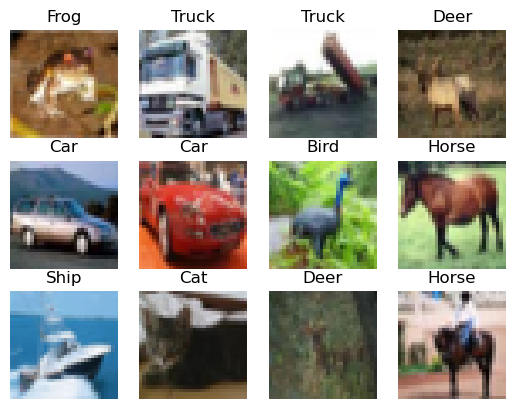

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Loading cifar10 dataset

# Displaying some of the images

classs = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure()
for _ in range(12):
    plt.subplot(3, 4, _ + 1)
    plt.imshow(x_train[_])
    plt.title(classs[y_train[_][0]])
    plt.axis('off')
plt.show()

In [3]:
# Shape of the data
print(f"Training set image shape: {x_train.shape}")
print(f"Test set image shape: {x_test.shape}")

Training set image shape: (50000, 32, 32, 3)
Test set image shape: (10000, 32, 32, 3)


### 2.1 Data preprocessing

In [4]:
# Normalising the data set in range 0-1

'''Since CIFAR - 10 dataset contains 8 bit RGB images which means the pixel values differs from 0 to 255
We need to scale this value to range 0-1 that can be done by dividing by 255'''

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
'''Since the labels in CIFAR -10 dataset are integer values which represents 10 diffrenet classes ranging from 0-9
We convert this into one hot encoded vectors which is required to perform multi class classification 
using softmax output layers'''

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

### 2.3 Spliting the data into train and validation set

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### 3.0 CNN Architectures (ResNet-18, AlexNet, and MobileNet)

#### 3.1 Building ResNet-18

In [6]:
# Defining resudul block first
def residual_block(x, filters, stride=1, l2_reg=None):
    skip_connection = x # Storing original input in skip_connection
    
    '''First Convolution Layer: Appyling a 3x3 convolution with a certain number of filters, 
    followed by batch normalisation and ReLU activation to speed up convergence and to introdice nonlinearity'''
    
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    '''Second Convolution Layer: Another 3x3 convolution is applied followedby 
    batch normalisation but before the ReLU activation we add skip connection'''
    
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    
    '''If the stride is not 1 the spatial dimensions of the input needs to be downsampled.
    We add 1x1 convolution to the skip connection to ensure  it matches the shape of the output'''
    
    if stride != 1:
        skip_connection  = Conv2D(filters, (1, 1), strides=
                                  stride, padding='same', kernel_regularizer=l2_reg)(skip_connection)
        skip_connection  = BatchNormalization()(skip_connection)
    x = Add()([x, skip_connection ])
    x = Activation('relu')(x)
    return x

def build_resnet18(input_shape=(32, 32, 3), total_class=10, l2_reg=None, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    
    '''First convolution layer uses 7x7 filter with 64 filters and a stride 
    of 2 (This helps to reduce the spatial dimensions of the input)
    and then batch normalisation and and ReLu activation is applied'''
    
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=l2_reg)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    '''A max pooling layer futher reduces the dimensions and extracts most important features'''
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    '''Now we start stacking the resudual blocks. ResNet has 4 stages and 2 blokcs in each stage. 
    Filters are being increased in each successive stages to capture more complex features and 
    compensate reduced spatial dimensions'''
    
    x = residual_block(x, 64, l2_reg=l2_reg) 
    # Initial downsampling is already done so we do not need it again in intial stage
    x = residual_block(x, 64, l2_reg=l2_reg) 
    x = residual_block(x, 128, stride=2, l2_reg=l2_reg) # Stride 2 donwsamples the input
    x = residual_block(x, 128) # Keeps the dimension same
    x = residual_block(x, 256, stride=2, l2_reg=l2_reg) # Stride 2 donwsamples the input
    x = residual_block(x, 256) # Keeps the dimension same
    x = residual_block(x, 512, stride=2, l2_reg=l2_reg) # Stride 2 donwsamples the input
    x = residual_block(x, 512) # Keeps the dimension same
    
    '''Now we use global average pooling to compute the avg of each feature map and reduce the 
    2D feature map into a single value and significantly reduce the number of parameters
    before the final classification layer. Finaly, fully Connected Layer with Softmax
    produces a probability distribution over 10 classes and allow the model to make predictions.'''
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(total_class, activation='softmax', kernel_regularizer=l2_reg)(x)
    model = Model(inputs, outputs)
    return model

#### 3.2 Building AlexNet 

In [7]:
def build_alexnet(input_shape=(32, 32, 3), total_class=10, l2_reg=None , dropout_rate=0.5): 
    '''The original input sape of AlexNet is modified to accomodate the 
    smaller image size of our dataset to preserve importan information'''
    
    
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               input_shape=input_shape, kernel_regularizer=l2_reg), # 1st Conv layer
        # 64 filters of size 3x3 with a stride of 1 for 32x32 sized images.
        
        MaxPooling2D(pool_size=(2, 2)),
        # maxpooling leyer to reduce the spatial dimensions by half 
        # using 2x2 pooling window. 32x32 to 16x16
        
        Conv2D(192, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg), # 2nd Conv layer
        
        MaxPooling2D(pool_size=(2, 2)), # Again reducing the spatial dimensions by half. 16x16 to 8x8
        
        Conv2D(384, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg), # 3rd Conv layer
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg), # 4th Conv layer
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg), # 5th Conv layer
        
        MaxPooling2D(pool_size=(2, 2)), # Again reducing the spatial dimensions by half. 8x8 to 4x4
        
        Flatten(), # 4x4 fature maps are flatten into a single 1D vector 
       
        Dense(1024, activation='relu', kernel_regularizer=l2_reg), # 1st FC layer
        Dropout(0.5), # To prevent overfitting
        Dense(512, activation='relu', kernel_regularizer=l2_reg),  # 2nd FC layer
        Dropout(0.5), # To prevent overfitting
        Dense(total_class, activation='softmax' , kernel_regularizer=l2_reg)  # Ouput FC layer
    ])
    return model

#### 3.3 MobileNetV2

In [8]:
def build_mobilenet(input_shape=(32, 32, 3), total_class=10, l2_reg=None, dropout_rate=0.5): # Setting matching input to our dataset
    mobilenet_model = MobileNetV2(include_top=False, input_shape=input_shape , weights=None) 
    # Loading MobileNetV2 excluding the top of the network that is used for classification in original MobileNetV2
    
    '''The 4D output form MobileNetV2 is flattened to 2D
    It turns into 1D vector for each image in the batch
    For instance, (batch_size, 1, 1, 1280) would become (batch_size, 1280)
    This is needed to feed the output into dense layer'''
    
    x = Flatten()(mobilenet_model.output)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2_reg)(x) 
    # A FC layer with 512 neurons and ReLU to combine extracted features from conv layers
    x = Dropout(dropout_rate)(x)
    
    x = Dense(total_class, activation='softmax', kernel_regularizer=l2_reg)(x) 
    # Final FC output layer produces a probability distribution over the 10 classes
    
    model = Model(inputs=mobilenet_model.input, outputs=x)
    return model

### 4.0 Cross-validation

In [9]:
def cross_validate_model(model_builder, x_train, y_train, kf, epochs=10, batch_size=128):
    val_acc_per_fold = [] # To store validation accuracy of each fold
    fold_history = []  # To store history of each fold
    
    # Seting up Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    
    for train_index, val_index in kf.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model = model_builder() #  Custom function to return compiled model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        # Compling the model with adam optimizer, loss function aand acuracy for evaluation
        
        history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                    validation_data=(x_val_fold, y_val_fold),
                    epochs=epochs, callbacks=[early_stopping]) # Fitting the model
        
        # Appending the history for plotting later
        fold_history.append(history.history)
        
        # Evaluating validation accuracy
        val_acc = model.evaluate(x_val_fold, y_val_fold, verbose=0)[1]
        val_acc_per_fold.append(val_acc)
        
        print(f'Validation accuracy for fold: {val_acc:.4f}')
        
    avg_val_acc = np.mean(val_acc_per_fold)
    print(f'\nAverage validation accuracy across folds: {avg_val_acc:.4f}')
    return avg_val_acc, fold_history
# Reference: https://pieriantraining.com/understanding-cross-validation-in-scikit-learn-with-cross_validate/

### 6.0 Preparing model for hyperparameter tuning

In [10]:
def model_with_hyperparams(learning_rate=0.001, dropout_rate=0.5, optimizer_name='adam', model_type='resnet'):
    # Define L2 regularization factor
    l2_reg = l2(0.001)

    if model_type == 'resnet':
        model = build_resnet18(l2_reg=l2_reg, dropout_rate=dropout_rate)  # Pass L2 reg and dropout
    elif model_type == 'alexnet':
        model = build_alexnet(l2_reg=l2_reg, dropout_rate=dropout_rate)
    elif model_type == 'mobilenet':
        model = build_mobilenet(l2_reg=l2_reg, dropout_rate=dropout_rate)

    # Setting optimiser based on input parameters
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### 7.0 Train and validate models with different hyperparameters (Hyperparameter tuning)

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

kf = KFold(n_splits=2, shuffle=True, random_state=42) # Using 2 fold only to run the program quicker

# To test different learning rates, optimisers, and models

# To store results for comparison
best_val_acc = 0
best_hyperparams = {}
best_history = None
all_histories = {}

# Training and validating models with different hyperparameters

           
for lr in [0.001, 0.0001]:
    for opt in ['adam', 'sgd']:
        for model_type in ['resnet', 'alexnet', 'mobilenet']:
            print(f'\nTraining {model_type} with {opt} optimizer and learning rate {lr}')
            
            # Building a new model for each configuration is handled by lambda
            # Passing a model-building function (not a built model) to cross_validate_model
            avg_val_acc, fold_history = cross_validate_model(lambda: model_with_hyperparams(
                learning_rate=lr, optimizer_name=opt, model_type=model_type), x_train, y_train, kf)
            
            # Saving each configuration and its history
            config_key = f'{model_type}_{opt}_lr{lr}'
            all_histories[config_key] = {
                'avg_val_acc': avg_val_acc,
                'history': fold_history
            }
            
            # Tracking the best model based on validation accuracy
            if avg_val_acc > best_val_acc:
                best_val_acc = avg_val_acc
                best_hyperparams = {'model': model_type, 'optimizer': opt, 'learning_rate': lr}
                best_history = fold_history



Training resnet with adam optimizer and learning rate 0.001
Epoch 1/10


C:\Users\tauhi\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.3008 - loss: 3.9986 - val_accuracy: 0.1276 - val_loss: 4.3001
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.4719 - loss: 2.9391 - val_accuracy: 0.1814 - val_loss: 3.9983
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.5159 - loss: 2.5321 - val_accuracy: 0.5129 - val_loss: 2.3724
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.5647 - loss: 2.1917 - val_accuracy: 0.4885 - val_loss: 2.2775
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5793 - loss: 1.9631 - val_accuracy: 0.4600 - val_loss: 2.2772
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.6023 - loss: 1.7680 - val_accuracy: 0.5381 - val_loss: 1.9010
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.6258 - loss: 1.6045 - val_accuracy: 0.4762 - val_loss: 2.0550
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.6400 - loss: 1.5170 - val_accuracy: 0.574

C:\Users\tauhi\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.1172 - loss: 3.3751 - val_accuracy: 0.2434 - val_loss: 2.0922
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.2549 - loss: 2.0565 - val_accuracy: 0.3242 - val_loss: 1.8517
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.3022 - loss: 1.9096 - val_accuracy: 0.3564 - val_loss: 1.8038
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.3268 - loss: 1.8581 - val_accuracy: 0.3973 - val_loss: 1.7083
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.3698 - loss: 1.7561 - val_accuracy: 0.3957 - val_loss: 1.7145
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 760ms/step - accuracy: 0.3958 - loss: 1.7102 - val_accuracy: 0.4278 - val_loss: 1.6408
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 749ms/step - accuracy: 0.4107 - loss: 1.6630 - val_accuracy: 0.4535 - val_loss: 1.5526
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 733ms/step - accuracy: 0.4340 - loss: 1.6299 -

157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 732ms/step - accuracy: 0.1019 - loss: 2.3536 - val_accuracy: 0.1009 - val_loss: 2.3270
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 748ms/step - accuracy: 0.0953 - loss: 2.3235 - val_accuracy: 0.0972 - val_loss: 2.3164
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 732ms/step - accuracy: 0.1005 - loss: 2.3149 - val_accuracy: 0.0972 - val_loss: 2.3120
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 733ms/step - accuracy: 0.1023 - loss: 2.3110 - val_accuracy: 0.0972 - val_loss: 2.3097
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 731ms/step - accuracy: 0.1039 - loss: 2.3089 - val_accuracy: 0.0972 - val_loss: 2.3083
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 734ms/step - accuracy: 0.1064 - loss: 2.3077 - val_accuracy: 0.0972 - val_loss: 2.3074
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 734ms/step - accuracy: 0.1066 - loss: 2.3067 - val_accuracy: 0.1009 - val_loss: 2.3066
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 746ms/step - accuracy: 0.1030 - loss: 2.30

157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5605 - loss: 2.1377 - val_accuracy: 0.4335 - val_loss: 2.3218
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5905 - loss: 1.9105 - val_accuracy: 0.3689 - val_loss: 2.8090
Validation accuracy for fold: 0.1188

Average validation accuracy across folds: 0.3408

Training alexnet with adam optimizer and learning rate 0.0001
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 731ms/step - accuracy: 0.1550 - loss: 3.2504 - val_accuracy: 0.2776 - val_loss: 1.9807
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 745ms/step - accuracy: 0.2653 - loss: 1.9901 - val_accuracy: 0.3438 - val_loss: 1.8215
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 740ms/step - accuracy: 0.3287 - loss: 1.8695 - val_accuracy: 0.3422 - val_loss: 1.8562
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 116s 739ms/step - accuracy: 0.3525 - loss: 1.8157 - val_accuracy: 0.4002 - val_loss: 1.7158
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 745ms/step - accuracy: 0.3848 

157/157 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5929 - loss: 1.9300 - val_accuracy: 0.4667 - val_loss: 2.4033
Validation accuracy for fold: 0.0991

Average validation accuracy across folds: 0.3350

Training alexnet with sgd optimizer and learning rate 0.0001
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 115s 714ms/step - accuracy: 0.1444 - loss: 3.3941 - val_accuracy: 0.2745 - val_loss: 2.0471
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 748ms/step - accuracy: 0.2780 - loss: 2.0247 - val_accuracy: 0.3510 - val_loss: 1.8226
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 749ms/step - accuracy: 0.3292 - loss: 1.8570 - val_accuracy: 0.3948 - val_loss: 1.7106
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 747ms/step - accuracy: 0.3796 - loss: 1.7584 - val_accuracy: 0.3883 - val_loss: 1.7393
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 744ms/step - accuracy: 0.3958 - loss: 1.7201 - val_accuracy: 0.4383 - val_loss: 1.6268
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 117s 747ms/step - accuracy: 0.422

### 8.0 Ploting training and validation accuracy/loss


Plotting results for configuration: resnet_adam_lr0.001 (Avg Val Acc: 0.3568)


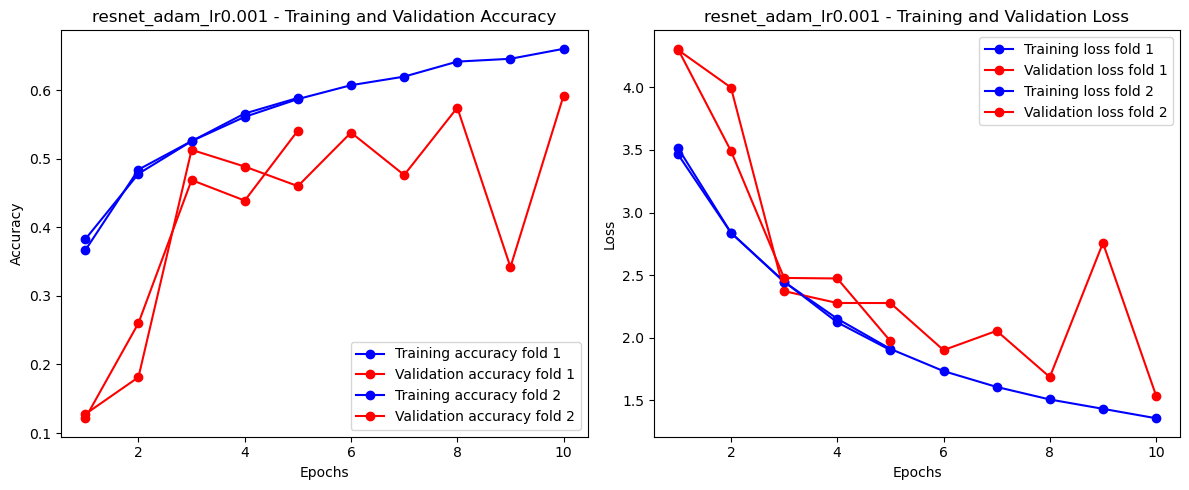


Plotting results for configuration: alexnet_adam_lr0.001 (Avg Val Acc: 0.3886)


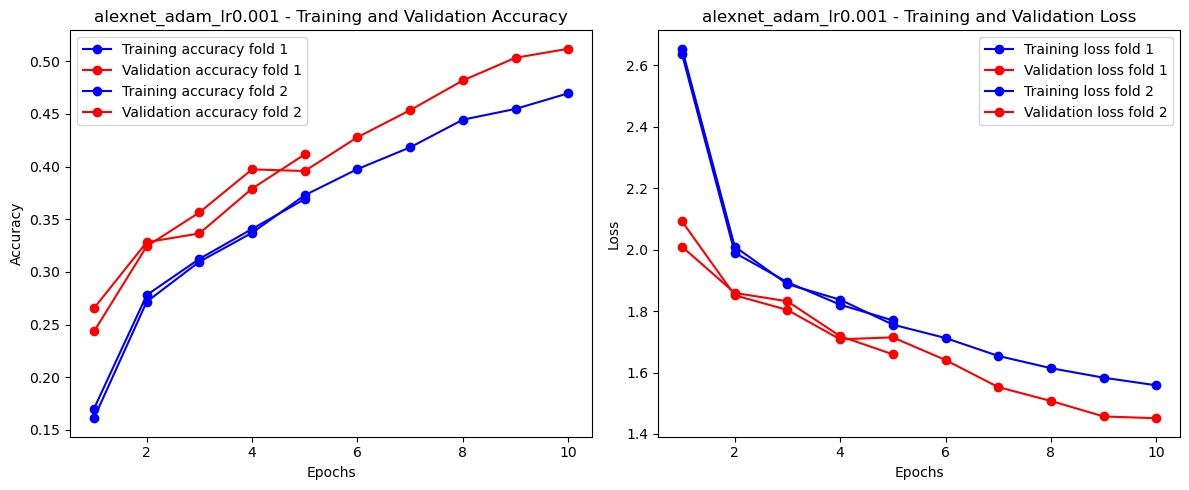


Plotting results for configuration: mobilenet_adam_lr0.001 (Avg Val Acc: 0.1002)


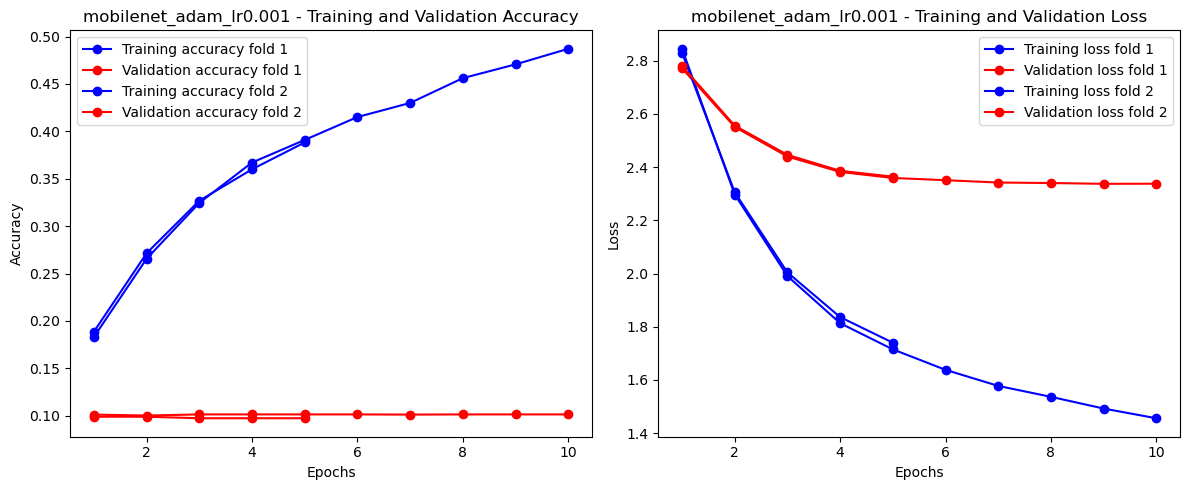


Plotting results for configuration: resnet_sgd_lr0.001 (Avg Val Acc: 0.3912)


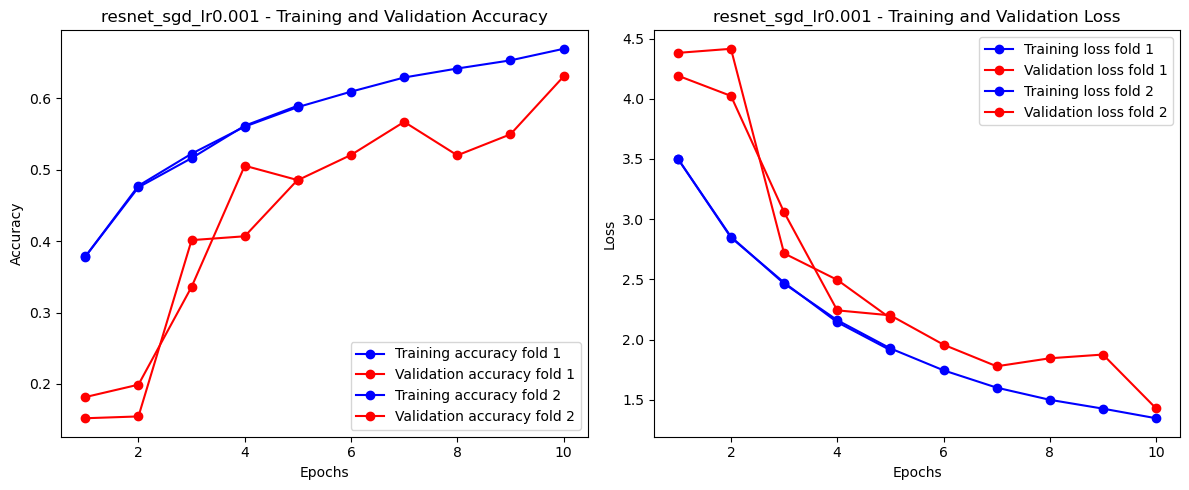


Plotting results for configuration: alexnet_sgd_lr0.001 (Avg Val Acc: 0.3172)


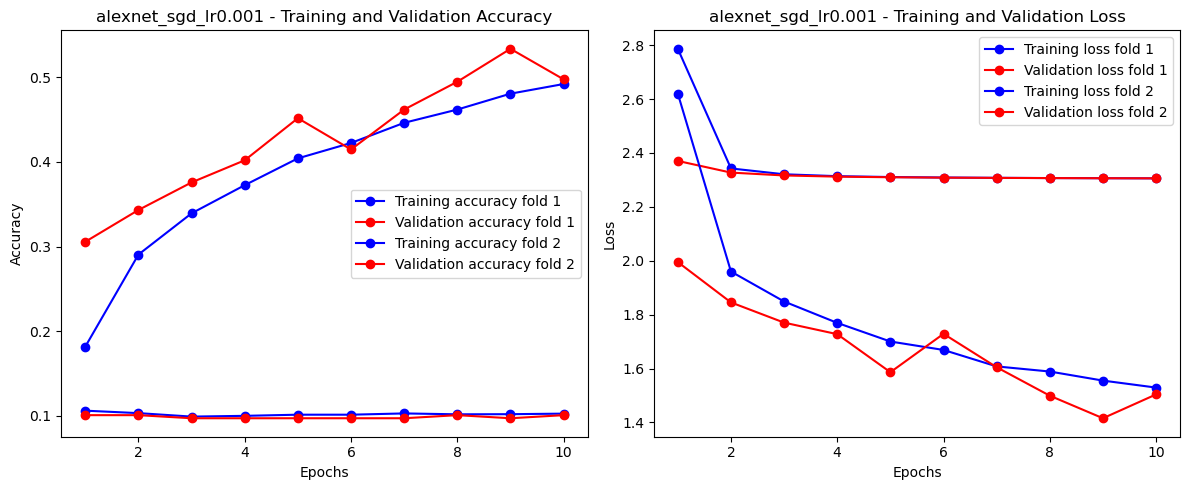


Plotting results for configuration: mobilenet_sgd_lr0.001 (Avg Val Acc: 0.0994)


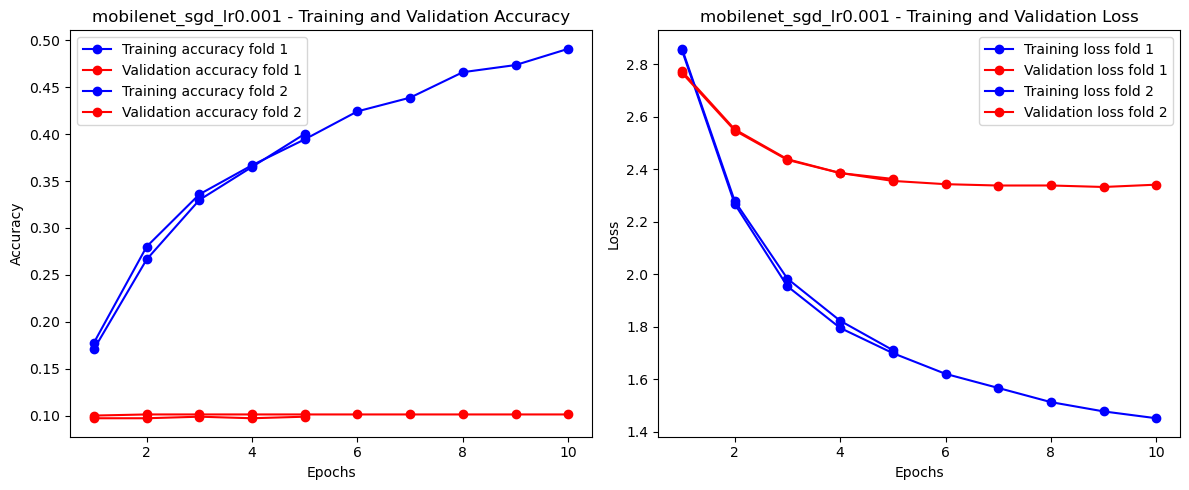


Plotting results for configuration: resnet_adam_lr0.0001 (Avg Val Acc: 0.3408)


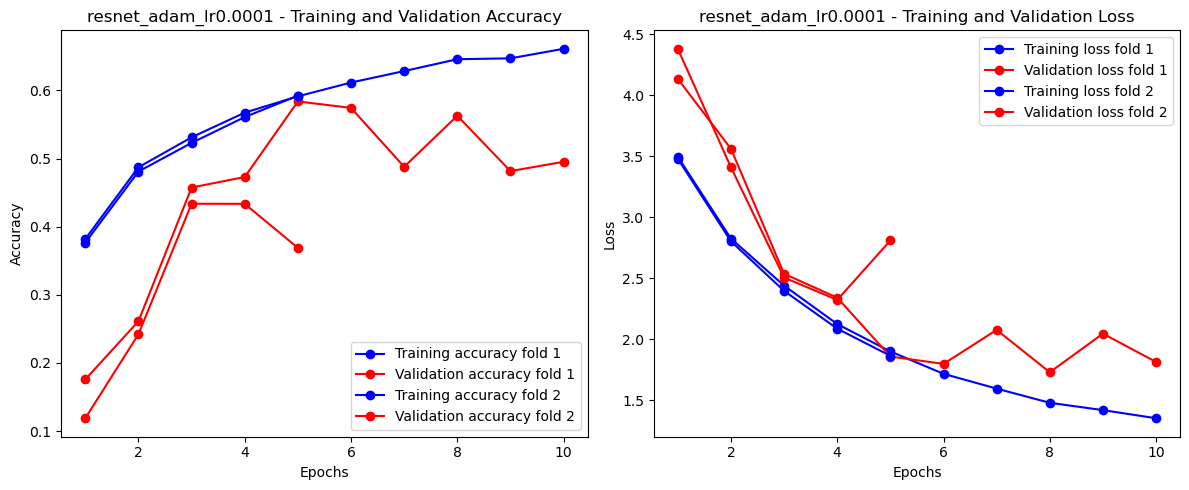


Plotting results for configuration: alexnet_adam_lr0.0001 (Avg Val Acc: 0.4210)


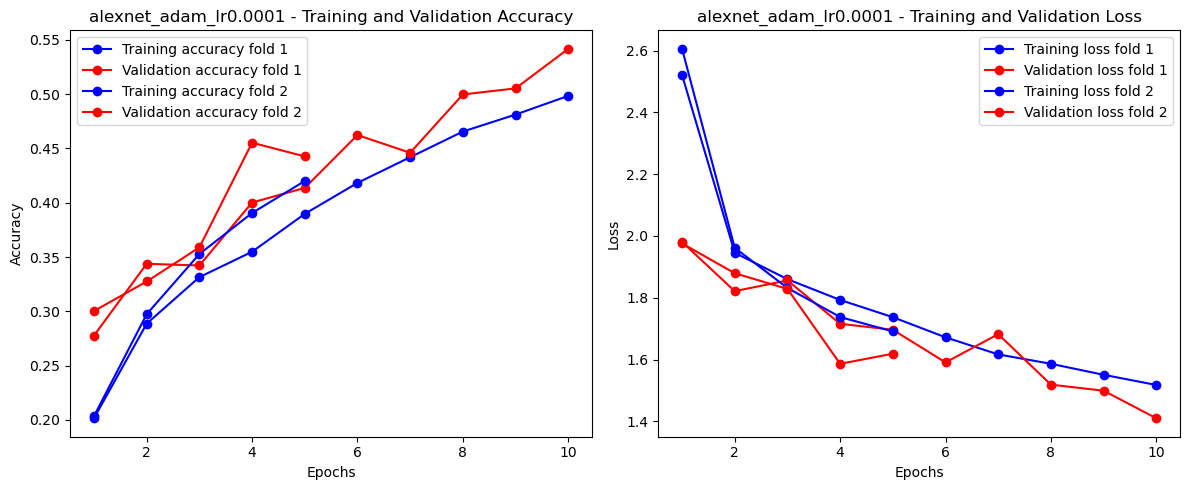


Plotting results for configuration: mobilenet_adam_lr0.0001 (Avg Val Acc: 0.1002)


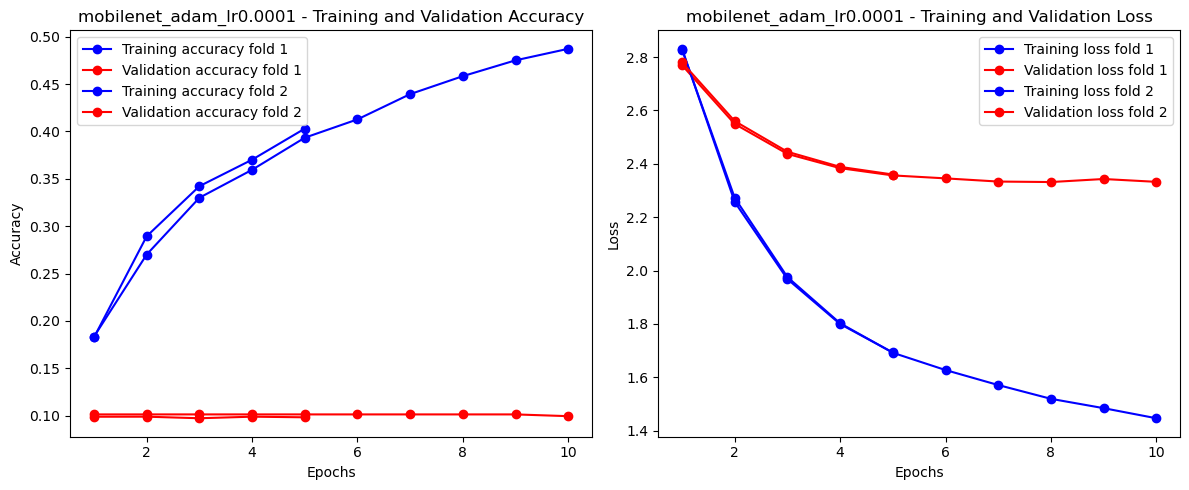


Plotting results for configuration: resnet_sgd_lr0.0001 (Avg Val Acc: 0.3350)


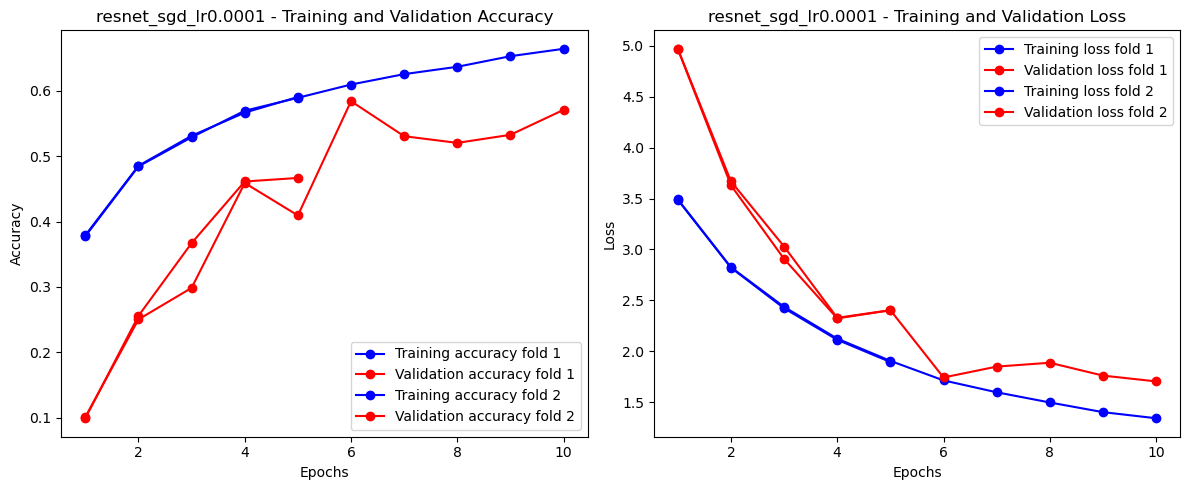


Plotting results for configuration: alexnet_sgd_lr0.0001 (Avg Val Acc: 0.3794)


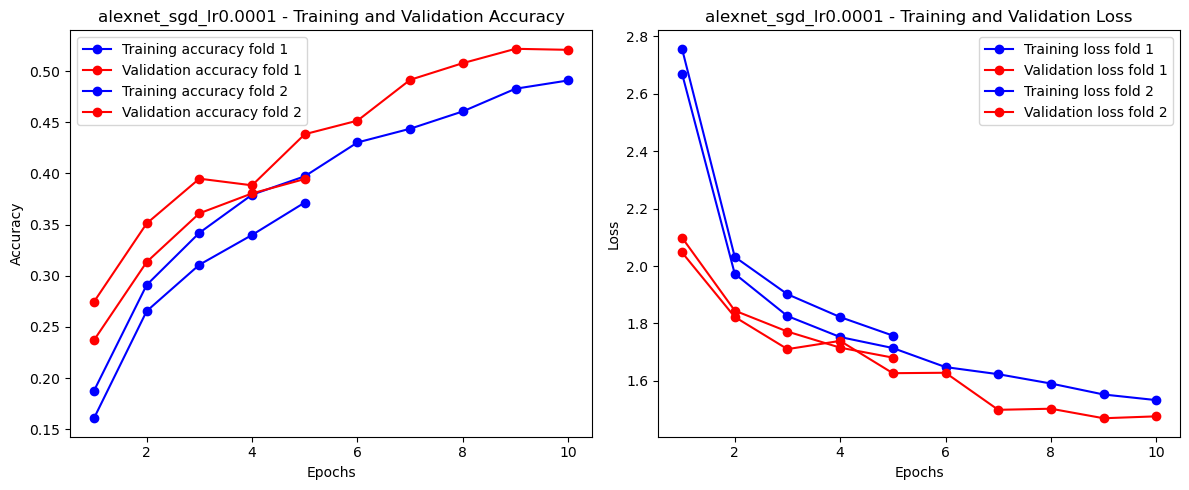


Plotting results for configuration: mobilenet_sgd_lr0.0001 (Avg Val Acc: 0.1006)


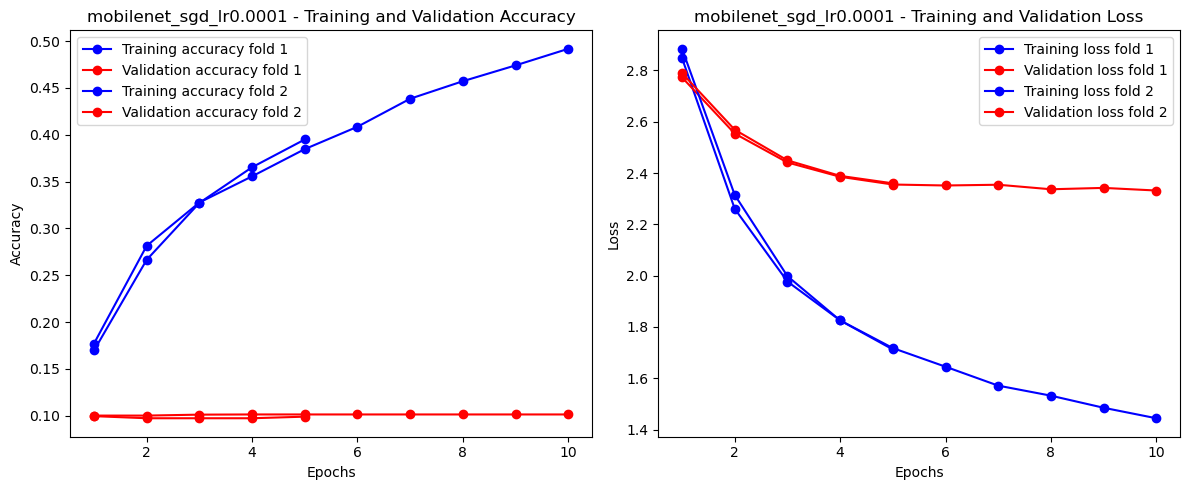

In [12]:
# Function to plot the history for each configuration
def plot_all_histories(histories):
    for config, data in histories.items():
        history = data['history']
        
        print(f'\nPlotting results for configuration: {config} (Avg Val Acc: {data["avg_val_acc"]:.4f})')
        
        # Plotting training and validation accuracy and loss for each fold
        plt.figure(figsize=(12, 5))
        
        for i, fold_history in enumerate(history):
            epochs = range(1, len(fold_history['accuracy']) + 1)
            
            # Accuracy plot
            plt.subplot(1, 2, 1)
            plt.plot(epochs, fold_history['accuracy'], 'bo-', label=f'Training accuracy fold {i+1}')
            plt.plot(epochs, fold_history['val_accuracy'], 'ro-', label=f'Validation accuracy fold {i+1}')
            plt.title(f'{config} - Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            
            # Loss plot
            plt.subplot(1, 2, 2)
            plt.plot(epochs, fold_history['loss'], 'bo-', label=f'Training loss fold {i+1}')
            plt.plot(epochs, fold_history['val_loss'], 'ro-', label=f'Validation loss fold {i+1}')
            plt.title(f'{config} - Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

# Plotting the history for all configurations
plot_all_histories(all_histories)

### 9.0 Ploting training and validation accuracy/loss for the best hperparameters

In [13]:
# Best hyperparameters
print(f'\nBest hyperparameters:')
print(f'Model: {best_hyperparams["model"]}')
print(f'Optimizer: {best_hyperparams["optimizer"]}')
print(f'Learning Rate: {best_hyperparams["learning_rate"]}')
print(f'Validation Accuracy: {best_val_acc:.4f}')



Best hyperparameters:
Model: alexnet
Optimizer: adam
Learning Rate: 0.0001
Validation Accuracy: 0.4210


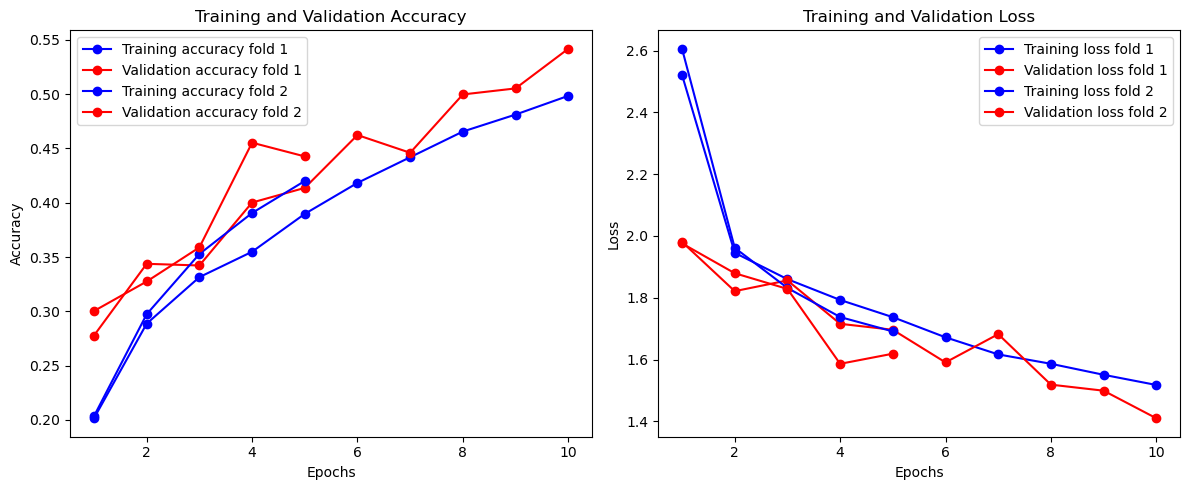

In [14]:
def plot_history(history):
    
    # Ploting training and validation accuracy and loss
    plt.figure(figsize=(12, 5))
    
    # Ploting for each fold (we have stored history for each fold)
    for i, fold_history in enumerate(history):
        epochs = range(1, len(fold_history['accuracy']) + 1)

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, fold_history['accuracy'], 'bo-', label=f'Training accuracy fold {i+1}')
        plt.plot(epochs, fold_history['val_accuracy'], 'ro-', label=f'Validation accuracy fold {i+1}')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, fold_history['loss'], 'bo-', label=f'Training loss fold {i+1}')
        plt.plot(epochs, fold_history['val_loss'], 'ro-', label=f'Validation loss fold {i+1}')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Ploting the history of the best model
plot_history(best_history)


### 10.0 Evaluating the best model on test set

In [16]:
# Training the best model from hyperparameter tuning on the full training data
# AlexNet with Adam optimizer and learning rate 0.0001
best_model = build_alexnet()
best_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training on the full training set (x_train and x_val combined)
history = best_model.fit(datagen.flow(x_train, y_train, batch_size=128), validation_data=(x_val, y_val), epochs=10)

best_model.summary()

# Evaluating on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 563ms/step - accuracy: 0.2049 - loss: 2.0979 - val_accuracy: 0.3683 - val_loss: 1.7758
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 180s 575ms/step - accuracy: 0.3852 - loss: 1.6578 - val_accuracy: 0.4900 - val_loss: 1.3769
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 189s 602ms/step - accuracy: 0.4613 - loss: 1.4602 - val_accuracy: 0.5027 - val_loss: 1.3748
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 601ms/step - accuracy: 0.5116 - loss: 1.3421 - val_accuracy: 0.5547 - val_loss: 1.2353
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 600ms/step - accuracy: 0.5482 - loss: 1.2430 - val_accuracy: 0.5618 - val_loss: 1.2661
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 601ms/step - accuracy: 0.5803 - loss: 1.1793 - val_accuracy: 0.6445 - val_loss: 0.9895
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 600ms/step - accuracy: 0.6023 - loss: 1.1139 - val_accuracy: 0.6419 - val_loss: 1.0026
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 189s 601ms/step - accuracy: 0.6235 -

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_205 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 16, 16, 192)         │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 8, 8, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_207 (Conv2D)                  │ (None, 8, 8, 384)           │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_208 (Conv2D)                  │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_209 (Conv2D)                  │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,930,528 (79.84 MB)

 Trainable params: 6,976,842 (26.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,953,686 (53.23 MB)

313/313 - 13s - 42ms/step - accuracy: 0.6819 - loss: 0.9056

Test Accuracy: 68.19%


In [17]:
# Training the best model from hyperparameter tuning on the full training data
# AlexNet with Adam optimizer and learning rate 0.001
best_model = build_alexnet()
best_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training on the full training set (x_train and x_val combined)
history = best_model.fit(datagen.flow(x_train, y_train, batch_size=128), validation_data=(x_val, y_val), epochs=10)

best_model.summary()

# Evaluating on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest Accuracy: {test_acc * 100:.2f}%')


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 599ms/step - accuracy: 0.2037 - loss: 2.0876 - val_accuracy: 0.4502 - val_loss: 1.4729
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 595ms/step - accuracy: 0.4393 - loss: 1.5100 - val_accuracy: 0.5658 - val_loss: 1.1964
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 597ms/step - accuracy: 0.5349 - loss: 1.2884 - val_accuracy: 0.5896 - val_loss: 1.1783
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 185s 591ms/step - accuracy: 0.5886 - loss: 1.1638 - val_accuracy: 0.6520 - val_loss: 0.9724
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 595ms/step - accuracy: 0.6218 - loss: 1.0690 - val_accuracy: 0.6652 - val_loss: 0.9491
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 186s 594ms/step - accuracy: 0.6578 - loss: 0.9757 - val_accuracy: 0.6470 - val_loss: 1.0223
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 595ms/step - accuracy: 0.6706 - loss: 0.9427 - val_accuracy: 0.7018 - val_loss: 0.8480
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 185s 591ms/step - accuracy: 0.7000 -

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_210 (Conv2D)                  │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_211 (Conv2D)                  │ (None, 16, 16, 192)         │         110,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 8, 8, 192)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_212 (Conv2D)                  │ (None, 8, 8, 384)           │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_213 (Conv2D)                  │ (None, 8, 8, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_214 (Conv2D)                  │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,930,528 (79.84 MB)

 Trainable params: 6,976,842 (26.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,953,686 (53.23 MB)

313/313 - 14s - 44ms/step - accuracy: 0.7196 - loss: 0.8081

Test Accuracy: 71.96%


*Acknowledgement: I acknowledge the use of internet sources, python libraries, gpt to understand and complete this project.*